In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
import os
import dotenv

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

### Mongo connection, extract and normalize

In [2]:
dotenv.load_dotenv()
MGURL = os.getenv("MGURL")
myclient = MongoClient(f"{MGURL}")
db = myclient.github

In [3]:
git = list(db.profiles.find({},{"_id":0, "company":0, "location":0, "email":0, "hireable":0}))

In [4]:
df = pd.json_normalize(git, "repos", ["name","repos_number","followers","created","updated"])

### Clean and prepare dataframe

In [5]:
print(df.shape)
df.head()

(1037132, 10)


,repo_name,forked,stars,language,forks,name,repos_number,followers,created,updated
0,AwesomeNER,False,6,Jupyter Notebook,2,Tarun Sudhams,23,33,2016-05-27T06:16:14Z,2020-05-05T07:34:00Z
1,coding-interview-university,True,2,None,1,Tarun Sudhams,23,33,2016-05-27T06:16:14Z,2020-05-05T07:34:00Z
2,COMP2396-assignments,False,0,Java,0,Tarun Sudhams,23,33,2016-05-27T06:16:14Z,2020-05-05T07:34:00Z
3,Computer-and-Communication-Networks,False,0,Python,1,Tarun Sudhams,23,33,2016-05-27T06:16:14Z,2020-05-05T07:34:00Z
4,Costa-Rican-Household-Poverty-Level-Prediction,False,0,HTML,4,Tarun Sudhams,23,33,2016-05-27T06:16:14Z,2020-05-05T07:34:00Z


In [6]:
df.created = df.created.str.replace(r"\b(?:(?!\d{4}-\d{2}).*)","")
df.updated = df.updated.str.replace(r"\b(?:(?!\d{4}-\d{2}).*)","")
df.drop(columns={"repo_name", "language"}, inplace=True)

In [7]:
df.isnull().sum()

forked              0
stars               0
forks               0
name            33898
repos_number        0
followers           0
created             0
updated             0
dtype: int64

In [8]:
df["years"] = df.updated.astype(int)-df.created.astype(int)
df.drop(columns={"created","updated"}, axis=1, inplace=True)
df.dropna(how="any", inplace=True)

In [9]:
print(df.shape)
df.isnull().sum()

(1003234, 7)


forked          0
stars           0
forks           0
name            0
repos_number    0
followers       0
years           0
dtype: int64

In [10]:
num = df.groupby(["name", "repos_number", "followers", "years"]).agg({"stars":"sum", "forks":"sum"}).reset_index()

In [11]:
num[num.name=="Tarun Sudhams"]

,name,repos_number,followers,years,stars,forks
33492,Tarun Sudhams,23,33,4,49,38


In [12]:
cat = df.groupby(["name","forked"]).size().unstack(fill_value=0).reset_index().rename(columns={"index":"name",False:"user_repo",True:"forked_repo"})

In [13]:
cat[cat.name=="Tarun Sudhams"]

forked,name,user_repo,forked_repo
32038,Tarun Sudhams,19,4


In [14]:
df = pd.merge(num, cat, on="name")

In [15]:
df[df.name=="Tarun Sudhams"]

,name,repos_number,followers,years,stars,forks,user_repo,forked_repo
33492,Tarun Sudhams,23,33,4,49,38,19,4


### Descriptive Analysis

In [16]:
print(df.shape)
df.head()

(41335, 8)


,name,repos_number,followers,years,stars,forks,user_repo,forked_repo
0,Aníbal Catheringer,2,1,6,0,0,2,0
1,Cohen,18,2,3,0,2,18,0
2,Enrico Antonello,43,14,7,7,2,28,15
3,Jakub Smadiš,16,1,3,0,0,3,13
4,Marián Černý,16,3,8,22,6,3,13


In [17]:
df.describe()

,repos_number,followers,years,stars,forks,user_repo,forked_repo
count,41335.000000,41335.000000,41335.000000,41335.000000,41335.000000,41335.000000,41335.000000
mean,24.288521,23.928680,6.178275,76.527979,20.784081,15.033410,16.244345
std,105.041222,339.126622,2.887503,998.011995,290.819093,53.370244,103.753181
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,3.000000,4.000000,0.000000,0.000000,3.000000,1.000000
50%,12.000000,6.000000,6.000000,3.000000,1.000000,7.000000,4.000000
75%,27.000000,13.000000,8.000000,14.000000,6.000000,16.000000,12.000000
max,14637.000000,57545.000000,12.000000,123102.000000,34154.000000,9349.000000,14433.000000


In [18]:
X = df.drop(columns={"name"})

In [19]:
#we can observe a lot of rows with at least 1 column > 1k. Mainly stars and forks, while any mean is higher than 400
outliers = df[(X>1000).any(1)]
print(outliers.shape)
outliers.head()

(549, 8)


,name,repos_number,followers,years,stars,forks,user_repo,forked_repo
361,Adam Coddington,185,174,10,1975,434,120,65
421,Adam Mckaig,141,358,12,2029,461,82,59
467,Adam Zapletal,31,72,11,1987,376,10,21
1080,Alberto Paro,122,129,12,1108,401,30,92
1083,Alberto Pettarin,49,72,7,1071,271,29,20


<function matplotlib.pyplot.show(*args, **kw)>

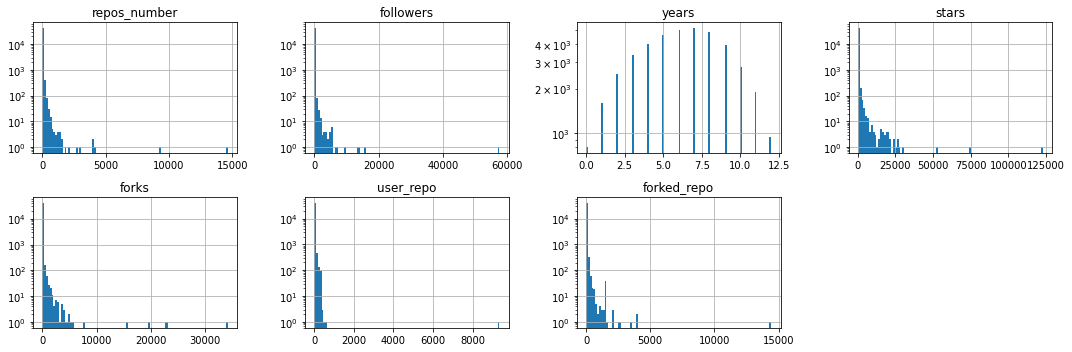

In [20]:
#we can see in all variables except for years and stars that the frequency of 0 es huge
figure = plt.figure(figsize=(15,5))

for n, c in enumerate(X.columns):
  ax = figure.add_subplot(2,4,n+1)
  ax.set_title(c)
  ax.set_yscale("log") #the log scale help us to have a better idea of our data when the distribution is not fair
  X[c].hist(ax=ax, bins=100)

figure.tight_layout() #this feature separate the graphs correctly
plt.show

Text(0.5, 1.0, 'Correlation matrix')

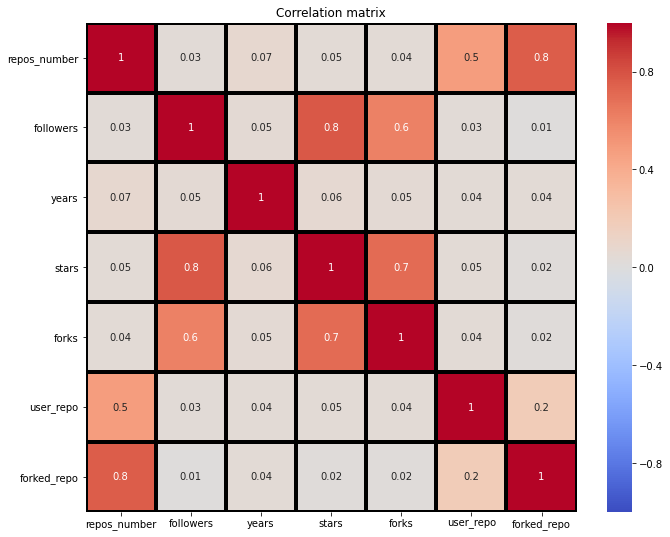

In [21]:
plt.figure(figsize=(11,9))

sns.heatmap(X.corr(), annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm' , linewidths=3, linecolor='black')

plt.title('Correlation matrix')

#### There is a big positive linear relation between followers, stars and forks. However none of the repo columns  neither yeas are related with the 3 previous vars. Therefore we will take these 3 vars as the main characteristics to determine the seniority of users

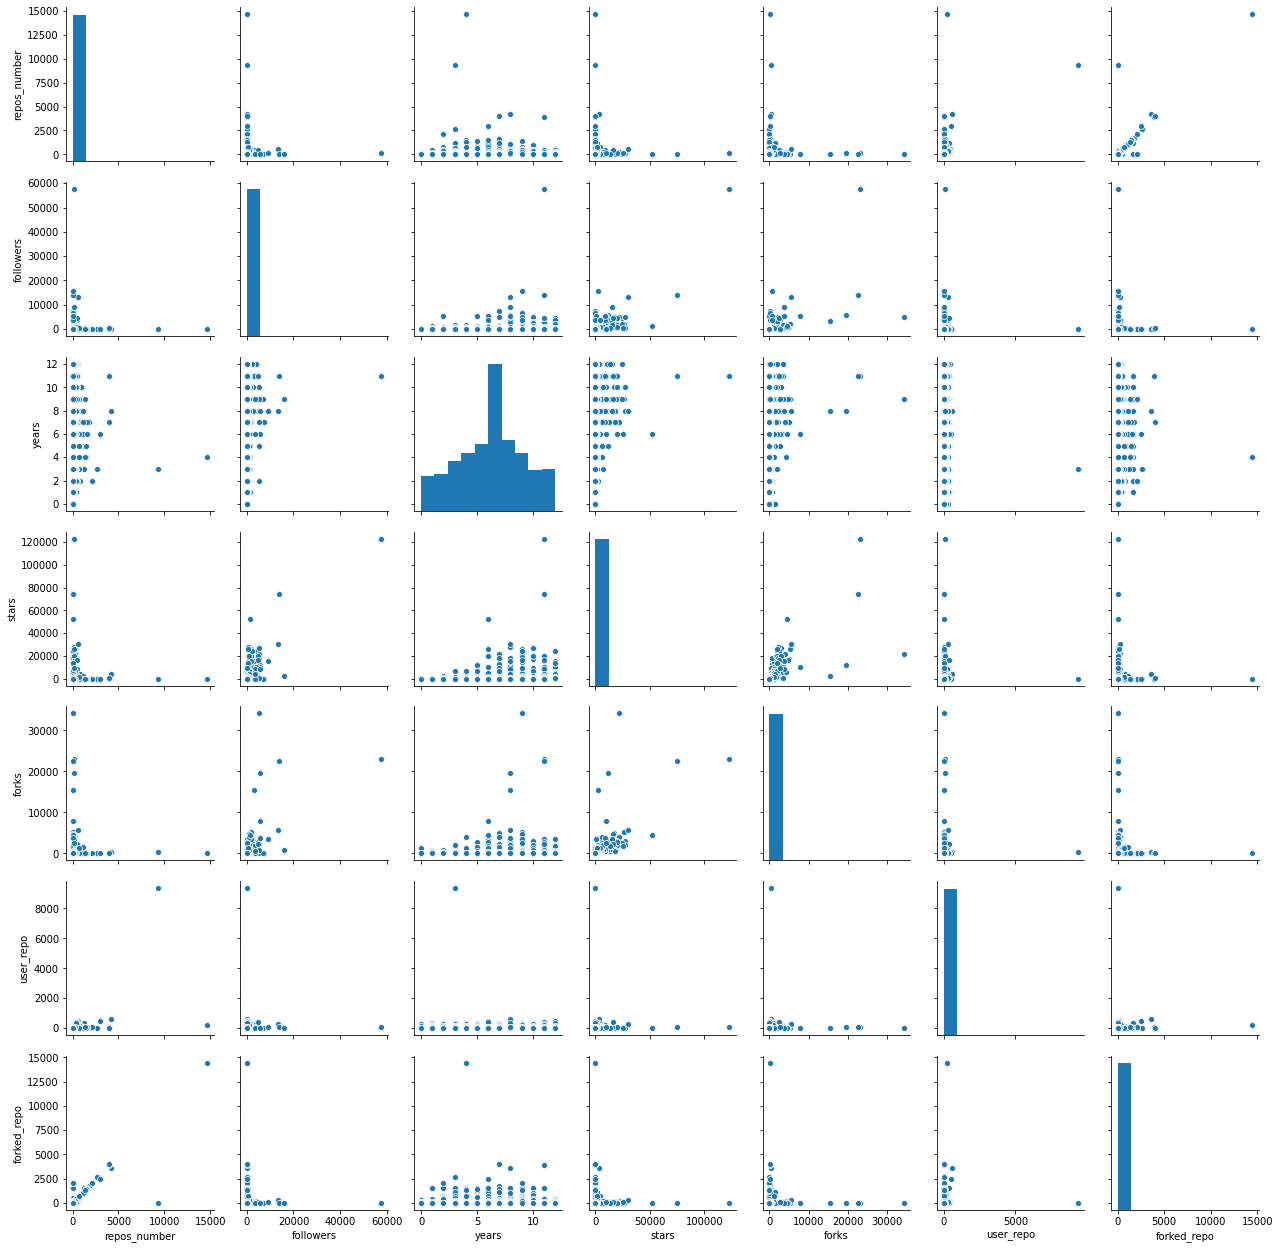

In [22]:
sns.pairplot(X)

#### Above we can see some columns with really huge outliers that could affect our cluster model. Therefore we will apply the Standard Scaler to eliminate them, which will be useful for the PCA reduction

In [23]:
#we will exclude the id and the repos_number as we will use the user_repo and forked_repo for clustering
name = df.name
repos = df.repos_number
X = df.drop(columns={"name","repos_number"})

### Scale

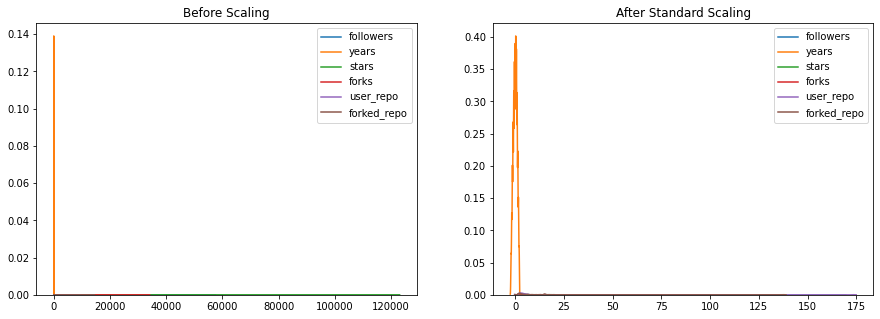

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

strans = scaler.fit_transform(X)

X_SS = pd.DataFrame(strans)
X_SS.columns = X.columns

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
ax1.set_title('Before Scaling')
for e in X.columns:
    sns.kdeplot(X[e], ax=ax1, legend=True)
ax2.set_title('After Standard Scaling')
for e in X_SS.columns:
    sns.kdeplot(X_SS[e], ax=ax2, legend=True)
plt.show()

#### We show it again

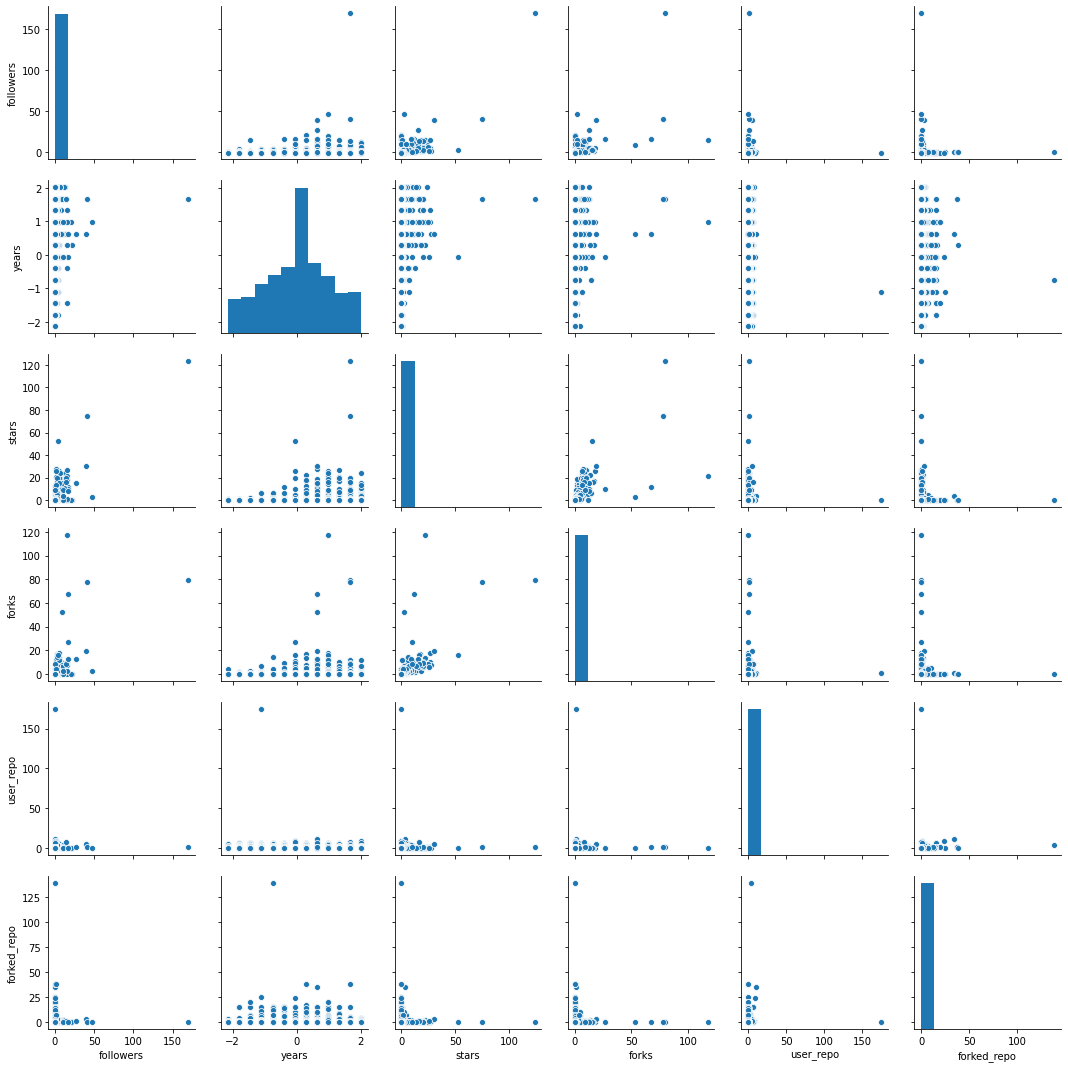

In [26]:
sns.pairplot(X_SS)

#### Before impletementing the PCA dimensionality reduction lets check the dimensions

/home/diego/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


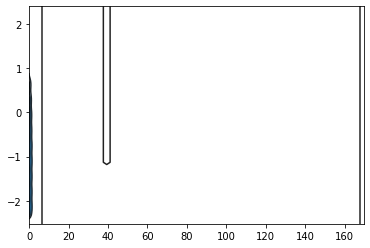

In [27]:
sns.kdeplot(X_SS)

#### Seems to be more than 3 

In [31]:
X_SS.shape

(41335, 6)

#### 6 dimensions actually

### PCA -- Choosing number of components

In [63]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_SS)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [58]:
pca.explained_variance_ratio_

array([0.40140565, 0.20026292, 0.1632997 , 0.13448881, 0.06655205,
       0.03399088])

Text(0, 0.5, 'Cummulative Explained Variance')

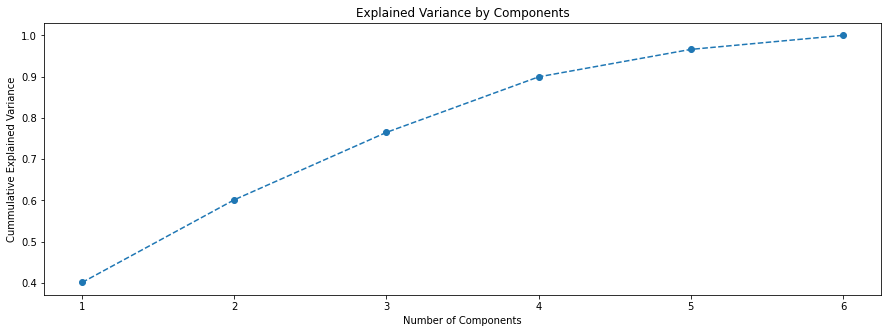

In [62]:
plt.figure(figsize=(15,5)) 
plt.plot(range(1,7), pca.explained_variance_ratio_.cumsum(), marker="o", linestyle="--")
plt.title("Explained Variance by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cummulative Explained Variance")

#### The graph shows the amount of variance captured (on the y-axis) depending on the number of components we include (the x-axis). A rule of thumb is to preserve around 80 % of the variance. So, in this instance, we decide to keep 3 components.

In [101]:
pca = PCA(n_components=3).fit(X_SS)
X_3d = pca.transform(X_SS)

In [102]:
X_3d.shape

(41335, 3)

In [66]:
pca.components_

array([[ 0.57359547,  0.07171377,  0.59796979,  0.55161715,  0.05559262,
         0.03009108],
       [-0.05129609,  0.24161356, -0.03999266, -0.04077377,  0.67987538,
         0.68811275],
       [ 0.03640513, -0.96760606,  0.0270922 ,  0.03116058,  0.1821904 ,
         0.16587606]])

In [67]:
pca.explained_variance_ratio_

array([0.40140565, 0.20026292, 0.1632997 ])

### Silhouette Score

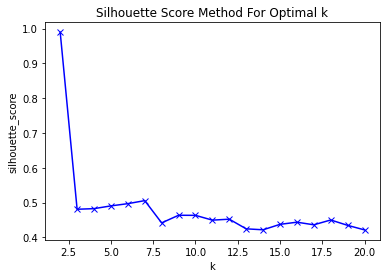

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.72 µs


In [68]:
#we use the silhouette method to determine the ideal number of clusters. Although our clusters objective is 4-7
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil = []
kmax = 20
klusters = range(2, kmax+1)
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in klusters:
    km = KMeans(n_clusters = k).fit(X_3d)
    labels = km.labels_
    sil.append(silhouette_score(X_3d, labels, metric = 'euclidean'))
    
plt.plot(klusters, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Score Method For Optimal k')
plt.show()
%time

- Standard Scaler --> Optimal Clusters 2

#### The optimal number of clusters is 2, but we want between 5-7 so we will start with 7, see how it goes and maybe we will exclude outliers

In [69]:
model = KMeans(n_clusters=7)

labels = model.fit_predict(X_3d)

In [76]:
df_pca_kmeans = pd.concat([df, pd.DataFrame(X_3d).rename(columns={0:"Component1", 1:"Component2", 2:"Component3"})], axis=1)
df_pca_kmeans["label"] = labels
df_pca_kmeans.head()

,name,repos_number,followers,years,stars,forks,user_repo,forked_repo,Component1,Component2,Component3,label
0,Aníbal Catheringer,2,1,6,0,0,2,0,-0.146773,-0.279238,-0.017489,3
1,Cohen,18,2,3,0,2,18,0,-0.199131,-0.326876,1.042769,3
2,Enrico Antonello,43,14,7,7,2,28,15,-0.060528,0.232609,-0.238055,0
3,Jakub Smadiš,16,1,3,0,0,3,13,-0.216470,-0.431309,1.012025,3
4,Marián Černý,16,3,8,22,6,3,13,-0.064344,-0.014952,-0.662047,0


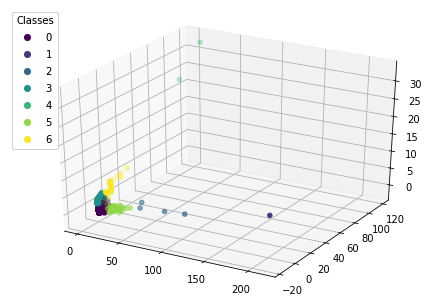

In [87]:
x = df_pca_kmeans.Component1
y = df_pca_kmeans.Component2
z = df_pca_kmeans.Component3

fig = plt.figure()
ax = Axes3D(fig)

scatter = ax.scatter(x, y, z, c=df_pca_kmeans.label)

legend = ax.legend(*scatter.legend_elements(), loc="upper left", title="Classes")

ax.add_artist(legend)
plt.show()

In [88]:
lab = df_pca_kmeans.label.value_counts()
lab

3    21630
0    19583
5       58
6       57
2        4
4        2
1        1
Name: label, dtype: int64

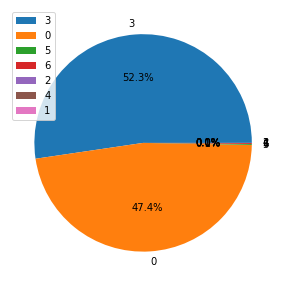

In [89]:
f, ax = plt.subplots(figsize=(15,5))
ax.pie(lab, labels=lab.keys(), autopct='%1.1f%%')
ax.legend(labels=lab.keys(), loc=2)

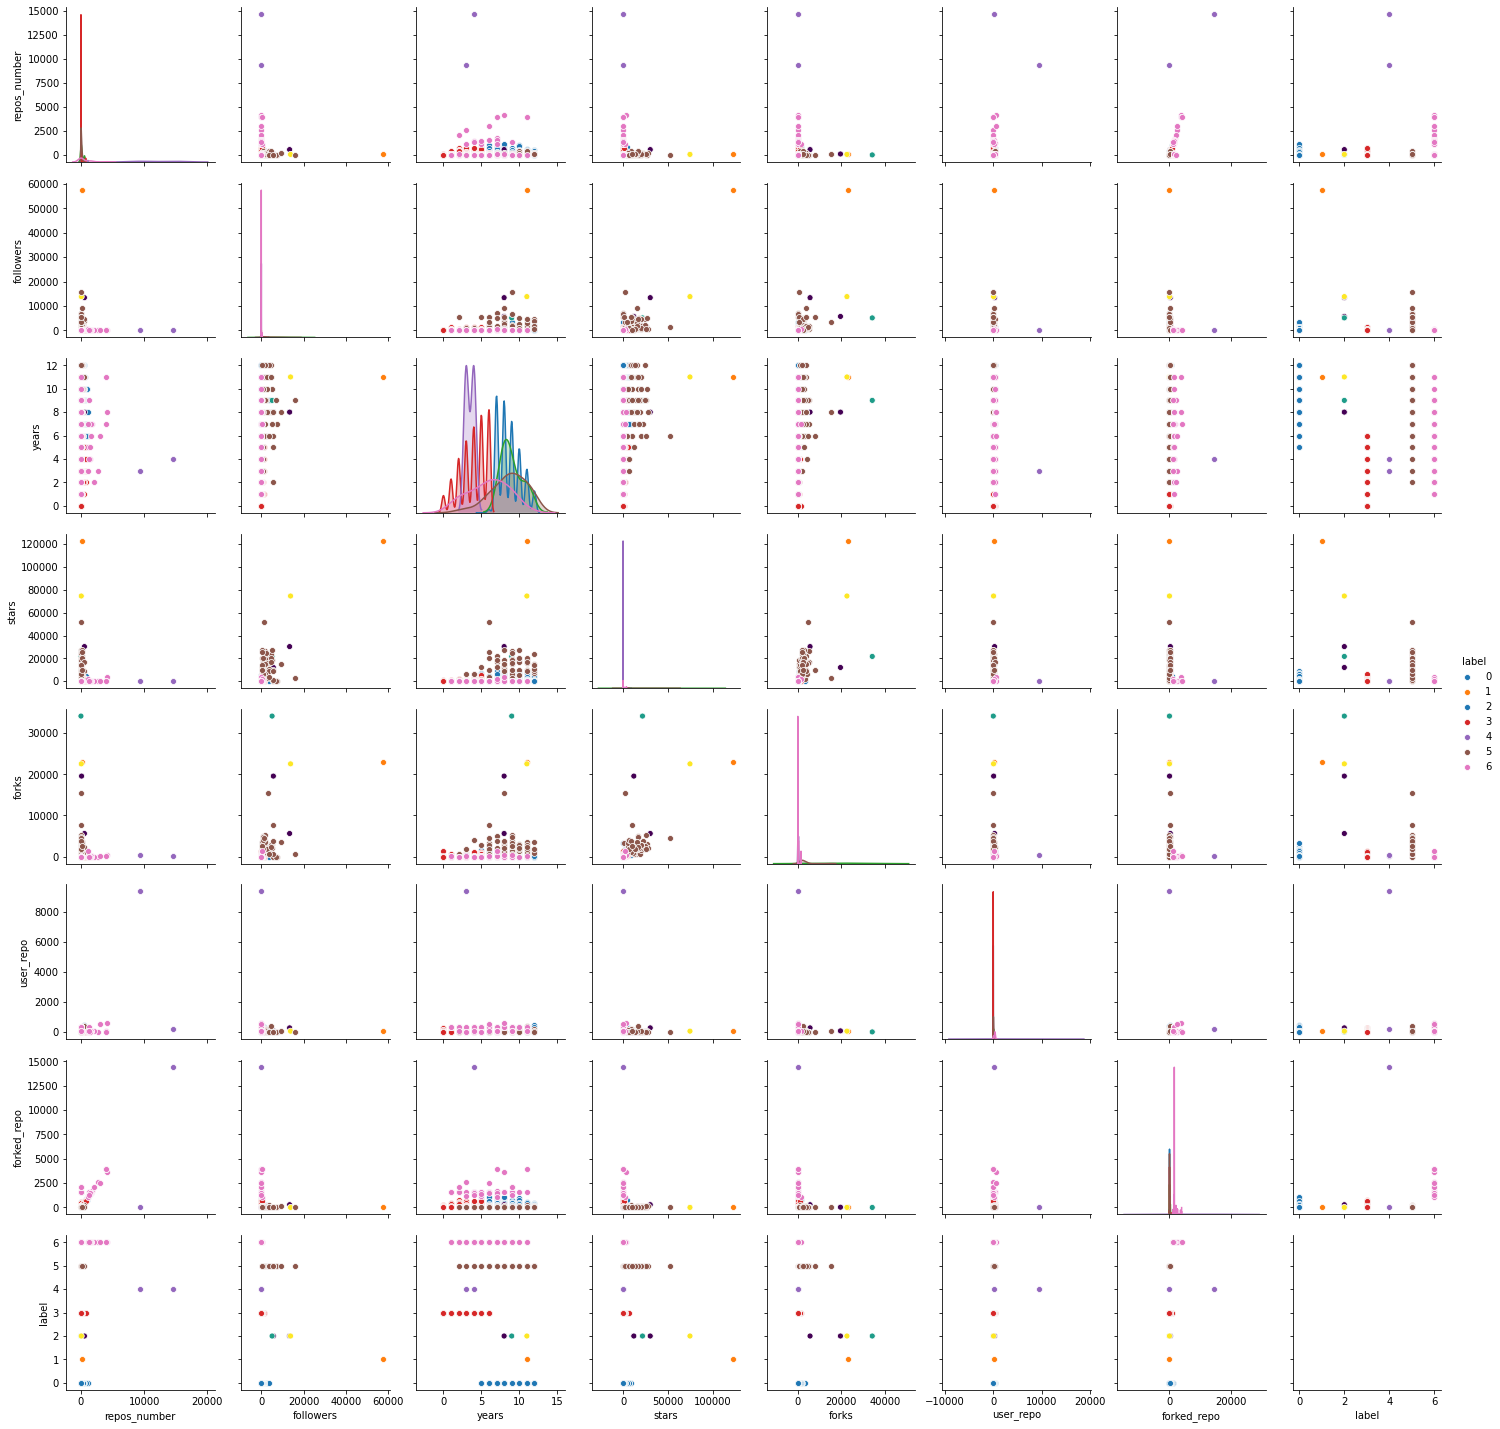

In [96]:
import warnings
warnings.filterwarnings("ignore")

sns.pairplot(df_pca_kmeans.iloc[:,[1,2,3,4,5,6,7,11]], hue="label")

### Conlusions from the graph:
- Forked_repos: the label 6 is clearly differentiated from the others
- Stars: label 1 is crearly differentiated and almost all user in the label 2
- Years: labels 0 and 3 are differentiated
- Repos_number: label 4 is differentiated

In [100]:
df_pca_kmeans.describe()

,repos_number,followers,years,stars,forks,user_repo,forked_repo,Component1,Component2,Component3,label
count,41335.000000,41335.000000,41335.000000,41335.000000,41335.000000,41335.000000,41335.000000,4.133500e+04,4.133500e+04,4.133500e+04,41335.000000
mean,24.288521,23.928680,6.178275,76.527979,20.784081,15.033410,16.244345,-4.870941e-17,-4.374550e-17,7.348664e-18,1.585557
std,105.041222,339.126622,2.887503,998.011995,290.819093,53.370244,103.753181,1.551932e+00,1.096178e+00,9.898595e-01,1.510477
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.992753e-01,-1.547162e+01,-2.033135e+00,0.000000
25%,5.000000,3.000000,4.000000,0.000000,0.000000,3.000000,1.000000,-1.688588e-01,-3.381623e-01,-6.781079e-01,0.000000
50%,12.000000,6.000000,6.000000,3.000000,1.000000,7.000000,4.000000,-9.848591e-02,-1.050380e-01,-5.404646e-03,3.000000
75%,27.000000,13.000000,8.000000,14.000000,6.000000,16.000000,12.000000,-2.080239e-02,1.526065e-01,6.823049e-01,3.000000
max,14637.000000,57545.000000,12.000000,123102.000000,34154.000000,9349.000000,14433.000000,2.149379e+02,1.184941e+02,3.293189e+01,6.000000


In [99]:
pd.set_option('display.max_columns', None)

df_pca_kmeans.groupby("label").describe()

repos_number                                                        \
             count          mean          std     min       25%      50%   
label                                                                      
0          19583.0     29.951080    47.100938     1.0      7.00     17.0   
1              1.0    102.000000          NaN   102.0    102.00    102.0   
2              4.0    184.500000   254.057080     9.0     49.50     84.0   
3          21630.0     16.161258    28.721041     1.0      3.00      9.0   
4              2.0  11993.000000  3739.180659  9349.0  10671.00  11993.0   
5             58.0    101.862069   105.593469     1.0     33.75     58.5   
6             57.0    651.438596  1106.286081     1.0      7.00     22.0   

                        followers                                      \
           75%      max     count          mean          std      min   
label                                                                   
0         35.0   1107.0   19583.0     27.195782    88.044650      0.0   
1        102.0    102.0       1.0  57545.000000          NaN  57545.0   
2        219.0    561.0       4.0   9516.500000  4744.334551   5119.0   
3         19.0    756.0   21630.0      9.234166    31.468110      0.0   
4      13315.0  14637.0       2.0     13.500000    19.091883      0.0   
5        149.5    457.0      58.0   2753.827586  2670.453987    238.0   
6       1240.0   4196.0      57.0     24.947368    65.685512      0.0   

                                               years                       \
            25%      50%       75%      max    count       mean       std   
label                                                                       
0          4.00      9.0     19.00   3587.0  19583.0   8.690446  1.486972   
1      57545.00  57545.0  57545.00  57545.0      1.0  11.000000       NaN   
2       5564.50   9557.0  13509.00  13833.0      4.0   9.000000  1.414214   
3          2.00      4.0      9.00   1522.0  21630.0   3.897226  1.721254   
4          6.75     13.5     20.25     27.0      2.0   3.500000  0.707107   
5        968.25   1888.5   3764.75  15832.0     58.0   8.637931  2.337327   
6          3.00      6.0     18.00    415.0     57.0   6.000000  2.598076   

                                         stars                               \
        min    25%   50%    75%   max    count           mean           std   
label                                                                         
0       5.0   7.00   8.0  10.00  12.0  19583.0      85.834193    392.826661   
1      11.0  11.00  11.0  11.00  11.0      1.0  123102.000000           NaN   
2       8.0   8.00   8.5   9.50  11.0      4.0   34676.500000  27664.604275   
3       0.0   3.00   4.0   5.00   6.0  21630.0      19.196718    125.608145   
4       3.0   3.25   3.5   3.75   4.0      2.0      53.000000      7.071068   
5       2.0   7.00   9.0  10.00  12.0     58.0   13759.741379   9018.980326   
6       1.0   4.00   6.0   8.00  11.0     57.0     126.122807    569.157086   

                                                             forks  \
            min        25%       50%        75%       max    count   
label                                                                
0           0.0       1.00       6.0      30.00    9101.0  19583.0   
1      123102.0  123102.00  123102.0  123102.00  123102.0      1.0   
2       12031.0   19290.25   26023.0   41409.25   74629.0      4.0   
3           0.0       0.00       1.0       6.00    6667.0  21630.0   
4          48.0      50.50      53.0      55.50      58.0      2.0   
5          27.0    7687.75   14043.0   18783.75   52132.0     58.0   
6           0.0       0.00       6.0      26.00    3854.0     57.0   

                                                                         \
               mean           std      min       25%      50%       75%   
label                                                                     
0         23.833376     96

#### As we can see from the graph the clusters could be taken as valid, however, 3/7 labels have 7 users in total, which is not logic, so we should be repeating the process, eliminating outliers until we have well distributed samples